 ### Question-Answering Machine


### Project  Statement: Working on a language understanding module for a chatbot. The chatbot must be able to answer questions about historical facts you hand it through a chat window: it must be able to refer back to older information in order to answer a question. Specifically, every question can be answered by exactly one statement that occurred in the past. I have at hand a large dataset of hand-annotated questions linked to supporting facts, and a set of candidate architectures that allow me to reason about memory. 

### Models that I am going to use to implement chatbot module:

#### 1. RNN, 
#### 2. LSTM
#### 3. End-to-end memory networks


##### 1. Import modules:

In [296]:
from __future__ import print_function
import numpy as np
import pandas as pd
import keras
import keras.utils
from keras import layers
from keras.layers import merge
from keras.layers import Flatten
from keras.models import Sequential, Model
from keras.preprocessing.text import Tokenizer
from keras.layers import Activation, SimpleRNN
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout
from keras.layers import add, dot, concatenate
from keras.layers import LSTM
from keras.utils.data_utils import get_file
from keras.preprocessing.sequence import pad_sequences
from functools import reduce
import tarfile
import re


##### 2. Import dataset: facts, questions and answers in text format

In [297]:
import os
import sys
train=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_train.txt')
test=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_test.txt')

##### 3. Create a Tokenizer- A lookup facility that converts words into numerical indices. This tokenizer is fitted on a vocabulary, and here, we use all words in both training and test data:

In [298]:
def create_tokenizer(trainingdata, testdata):
    f=open(trainingdata, "r")
    text=[]

    for line in f:
        m=re.match("^\d+\s([^\.]+)[\.].*",line.rstrip())
        if m:
            text.append(m.group(1))
        else:
            m=re.match("^\d+\s([^\?]+)[\?]\s\t([^\t]+)",line.rstrip())
            if m:
                text.append(m.group(1)+' '+m.group(2))
    f.close()

    f=open(testdata, "r")
    for line in f:
        m=re.match("^\d+\s([^\.]+)[\.].*",line.rstrip())
        if m:
            text.append(m.group(1))
        else:
            m=re.match("^\d+\s([^\?]+)[\?].*",line.rstrip())
            if m:
                text.append(m.group(1))
    f.close()

    vocabulary=set([word for word in text])
    max_words = len(vocabulary)
    tokenizer = Tokenizer(num_words=max_words, char_level=False, split=' ')
    tokenizer.fit_on_texts(text)
    return tokenizer, max_words

In [299]:
def process_stories_n_context(filename,tokenizer,vocab_size,use_context=context):
    f=open(filename,"r")
    X=[]
    Q=[]
    y=[]
    max_story_len=0
    max_query_len=0

    for line in f:
        m=re.match("^(\d+)\s(.+)\.",line.rstrip())
        if m:
            if int(m.group(1))==1:
                story={}
            story[int(m.group(1))]=m.group(2)
        else:
            m=re.match("^\d+\s(.+)\?\s\t([^\t]+)\t(.+)",line.rstrip())
            if m:
                question=m.group(1)
                answer=m.group(2)
                answer_ids=[int(x) for x in m.group(3).split(" ")]
                facts=' '.join([story[id] for id in answer_ids])
                all_facts=' '.join([story[id] for id in story])
                facts_v=vectorize(facts,tokenizer)
                all_facts_v=vectorize(all_facts,tokenizer)

                if use_context==0:
                    vectorized_fact=facts_v
                elif use_context==-1:
                    vectorized_fact=all_facts_v
                else:
                    x=min(use_context, len(story))
                    facts=' '.join([story[id] for id in answer_ids])+' '
                    n=0
                    for id in story:
                        if n<x and id not in answer_ids:
                            facts+=story[id]+' '
                            n+=1
                    vectorized_fact=vectorize(facts,tokenizer)
                l=len(vectorized_fact)
                if l>max_story_len:
                    max_story_len=l
                vectorized_question=vectorize(question,tokenizer)
                l=len(vectorized_question)
                if l>max_query_len:
                    max_query_len=l

                vectorized_answer=vectorize(answer,tokenizer)

                X.append(vectorized_fact)
                Q.append(vectorized_question)
                answer=np.zeros(vocab_size)
                answer[vectorized_answer[0]]=1
                y.append(answer)
    f.close()

    return np.array(X),np.array(Q),np.array(y), max_story_len, max_query_len

In [300]:
def vectorize(s, tokenizer):
    vector=tokenizer.texts_to_sequences([s])
    return vector[0]

In [301]:
def create_model(trainingData, testData, context):
    tokenizer,vocab_size=create_tokenizer(trainingData,testData)

    X_tr,Q_tr,y_tr,max_story_len_tr, max_query_len_tr=process_stories_n_context(trainingData,tokenizer,vocab_size,use_context=context)
    X_te,Q_te,y_te, max_story_len_te, max_query_len_te=process_stories_n_context(testData,tokenizer,vocab_size,use_context=context)

    max_story_len=max(max_story_len_tr, max_story_len_te)
    max_query_len=max(max_query_len_tr, max_query_len_te)

    X_tr=pad_sequences(X_tr,max_story_len)
    Q_tr=pad_sequences(Q_tr, max_query_len)
    X_te=pad_sequences(X_te,max_story_len)
    Q_te=pad_sequences(Q_te,max_query_len)

    embedding=layers.Embedding(vocab_size,100)

    story = layers.Input(shape=(max_story_len,), dtype='int32')
    encoded_story = embedding(story)
    encoded_story = SimpleRNN(30)(encoded_story)

    question = layers.Input(shape=(max_query_len,), dtype='int32')
    encoded_question = embedding(question)
    encoded_question = SimpleRNN(30)(encoded_question)

    merged = layers.concatenate([encoded_story, encoded_question])
    preds = layers.Dense(vocab_size, activation='softmax')(merged)

    model = Model([story, question], preds)
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    #print(X_te,Q_te)

    return X_tr,Q_tr,y_tr,X_te,Q_te,y_te,model



In [303]:
#def run_evaluate(trainingData, testData, context=6):
import os
import sys
train=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_train.txt')
test=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_test.txt')

context1=0
X_tr,Q_tr,y_tr,X_te,Q_te,y_te,model1=create_model(train,test,context1)
print('Training')
history1=model1.fit([X_tr, Q_tr], y_tr,batch_size=32,epochs=30, verbose=1,validation_split=0.1, shuffle=False)
print('Evaluation for context=0')
loss1, acc1 = model1.evaluate([X_te,Q_te], y_te,batch_size=32)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss1, acc1))


Training
Train on 9000 samples, validate on 1000 samples
Epoch 1/30
9000/9000 [==============================] - 12s 1ms/step - loss: 1.0589 - acc: 0.8548 - val_loss: 0.0591 - val_acc: 1.0000
Epoch 2/30
9000/9000 [==============================] - 3s 278us/step - loss: 0.0276 - acc: 1.0000 - val_loss: 0.0135 - val_acc: 1.0000
Epoch 3/30
9000/9000 [==============================] - 3s 289us/step - loss: 0.0093 - acc: 1.0000 - val_loss: 0.0064 - val_acc: 1.0000
Epoch 4/30
9000/9000 [==============================] - 3s 284us/step - loss: 0.0049 - acc: 1.0000 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 5/30
9000/9000 [==============================] - 3s 296us/step - loss: 0.0031 - acc: 1.0000 - val_loss: 0.0025 - val_acc: 1.0000
Epoch 6/30
9000/9000 [==============================] - 3s 291us/step - loss: 0.0021 - acc: 1.0000 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 7/30
9000/9000 [==============================] - 3s 287us/step - loss: 0.0016 - acc: 1.0000 - val_loss: 0.0013 - val_acc:

In [304]:
import os
import sys
train=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_train.txt')
test=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_test.txt')

context2=2
X_tr,Q_tr,y_tr,X_te,Q_te,y_te,model2=create_model(train,test,context2)

print('Training')
history2=model2.fit([X_tr, Q_tr], y_tr,batch_size=32,epochs=30, verbose=1,validation_split=0.1, shuffle=False)

print('Evaluation for context=2')
loss2, acc2 = model2.evaluate([X_te,Q_te], y_te,batch_size=32)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss2, acc2))

Training
Train on 9000 samples, validate on 1000 samples
Epoch 1/30
9000/9000 [==============================] - 15s 2ms/step - loss: 1.8595 - acc: 0.3059 - val_loss: 1.0835 - val_acc: 0.4800
Epoch 2/30
9000/9000 [==============================] - 3s 342us/step - loss: 0.7118 - acc: 0.7593 - val_loss: 0.4134 - val_acc: 0.8780
Epoch 3/30
9000/9000 [==============================] - 3s 370us/step - loss: 0.2354 - acc: 0.9762 - val_loss: 0.1149 - val_acc: 0.9970
Epoch 4/30
9000/9000 [==============================] - 3s 357us/step - loss: 0.0879 - acc: 0.9958 - val_loss: 0.0473 - val_acc: 0.9980
Epoch 5/30
9000/9000 [==============================] - 3s 358us/step - loss: 0.0361 - acc: 0.9994 - val_loss: 0.0245 - val_acc: 1.0000
Epoch 6/30
9000/9000 [==============================] - 3s 362us/step - loss: 0.0227 - acc: 0.9992 - val_loss: 0.0498 - val_acc: 0.9930
Epoch 7/30
9000/9000 [==============================] - 3s 344us/step - loss: 0.0236 - acc: 0.9979 - val_loss: 0.0105 - val_acc:

In [305]:
#def run_evaluate(trainingData, testData, context=6):
import os
import sys
train=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_train.txt')
test=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_test.txt')


context3=4
X_tr,Q_tr,y_tr,X_te,Q_te,y_te,model3=create_model(train,test,context3)

print('Training')
history3=model3.fit([X_tr, Q_tr], y_tr,batch_size=32,epochs=30, verbose=1,validation_split=0.1, shuffle=False)

print('Evaluation for context=4')
loss3, acc3 = model3.evaluate([X_te,Q_te], y_te,batch_size=32)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss3, acc3))

Training
Train on 9000 samples, validate on 1000 samples
Epoch 1/30
9000/9000 [==============================] - 11s 1ms/step - loss: 2.1087 - acc: 0.1657 - val_loss: 1.7949 - val_acc: 0.1710
Epoch 2/30
9000/9000 [==============================] - 4s 421us/step - loss: 1.7555 - acc: 0.2191 - val_loss: 1.6417 - val_acc: 0.2860
Epoch 3/30
9000/9000 [==============================] - 4s 479us/step - loss: 1.6104 - acc: 0.2882 - val_loss: 1.4196 - val_acc: 0.3900
Epoch 4/30
9000/9000 [==============================] - 4s 429us/step - loss: 1.2135 - acc: 0.4547 - val_loss: 1.0745 - val_acc: 0.5320
Epoch 5/30
9000/9000 [==============================] - 4s 444us/step - loss: 0.8829 - acc: 0.6510 - val_loss: 0.7714 - val_acc: 0.7110
Epoch 6/30
9000/9000 [==============================] - 4s 430us/step - loss: 0.6329 - acc: 0.8022 - val_loss: 0.5247 - val_acc: 0.8240
Epoch 7/30
9000/9000 [==============================] - 4s 425us/step - loss: 0.4680 - acc: 0.8563 - val_loss: 0.4061 - val_acc:

In [308]:
#def run_evaluate(trainingData, testData, context=6):
import os
import sys
train=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_train.txt')
test=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_test.txt')


context4=6
X_tr,Q_tr,y_tr,X_te,Q_te,y_te,model4=create_model(train,test,context4)

history4=model4.fit([X_tr, Q_tr], y_tr,batch_size=32,epochs=30, verbose=1,validation_split=0.1, shuffle=False)

print('Evaluation for context=6')
loss4, acc4 = model4.evaluate([X_te,Q_te], y_te,batch_size=32)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss4, acc4))

Train on 9000 samples, validate on 1000 samples
Epoch 1/30
9000/9000 [==============================] - 13s 1ms/step - loss: 2.0935 - acc: 0.1662 - val_loss: 1.7975 - val_acc: 0.1660
Epoch 2/30
9000/9000 [==============================] - 4s 497us/step - loss: 1.7993 - acc: 0.1677 - val_loss: 1.7942 - val_acc: 0.1780
Epoch 3/30
9000/9000 [==============================] - 4s 497us/step - loss: 1.7967 - acc: 0.1731 - val_loss: 1.7934 - val_acc: 0.1690
Epoch 4/30
9000/9000 [==============================] - 5s 506us/step - loss: 1.7956 - acc: 0.1748 - val_loss: 1.7929 - val_acc: 0.1690
Epoch 5/30
9000/9000 [==============================] - 5s 533us/step - loss: 1.7950 - acc: 0.1762 - val_loss: 1.7927 - val_acc: 0.1720
Epoch 6/30
9000/9000 [==============================] - 5s 534us/step - loss: 1.7945 - acc: 0.1772 - val_loss: 1.7925 - val_acc: 0.1720 loss - ETA: 1s -
Epoch 7/30
9000/9000 [==============================] - 5s 506us/step - loss: 1.7941 - acc: 0.1779 - val_loss: 1.7916 - 

In [309]:
#def run_evaluate(trainingData, testData, context=6):
import os
import sys
train=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_train.txt')
test=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_test.txt')

context5=-1
X_tr,Q_tr,y_tr,X_te,Q_te,y_te,model5=create_model(train,test,context5)
print('Training')

history5=model5.fit([X_tr, Q_tr], y_tr,batch_size=32,epochs=30, verbose=1,validation_split=0.1, shuffle=False)

print('Evaluation for context=All')
loss5, acc5 = model5.evaluate([X_te,Q_te], y_te,batch_size=32)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss5, acc5))
#pred=model.pred()

Training
Train on 9000 samples, validate on 1000 samples
Epoch 1/30
9000/9000 [==============================] - 15s 2ms/step - loss: 1.9705 - acc: 0.3746 - val_loss: 1.4163 - val_acc: 0.5380
Epoch 2/30
9000/9000 [==============================] - 5s 607us/step - loss: 1.3183 - acc: 0.5421 - val_loss: 1.2611 - val_acc: 0.5300
Epoch 3/30
9000/9000 [==============================] - 5s 575us/step - loss: 1.2033 - acc: 0.5398 - val_loss: 1.1854 - val_acc: 0.5290
Epoch 4/30
9000/9000 [==============================] - 5s 595us/step - loss: 1.1610 - acc: 0.5364 - val_loss: 1.1678 - val_acc: 0.5250
Epoch 5/30
9000/9000 [==============================] - 7s 738us/step - loss: 1.1389 - acc: 0.5357 - val_loss: 1.1512 - val_acc: 0.5180
Epoch 6/30
9000/9000 [==============================] - 5s 573us/step - loss: 1.1224 - acc: 0.5360 - val_loss: 1.1470 - val_acc: 0.5130
Epoch 7/30
9000/9000 [==============================] - 5s 590us/step - loss: 1.1103 - acc: 0.5382 - val_loss: 1.1393 - val_acc:

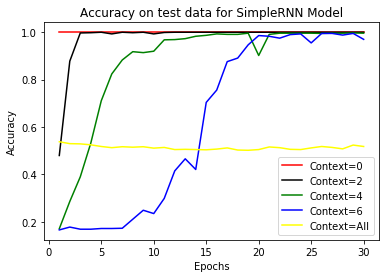

In [313]:
import matplotlib.pyplot as plt
plt.figsize=(16,4)
history1_dict = history1.history
#history_dict.keys()
history2_dict = history2.history
history3_dict = history3.history
history4_dict = history4.history
history5_dict = history5.history
acc_values1 = history1_dict['val_acc']
acc_values2 = history2_dict['val_acc']
acc_values3 = history3_dict['val_acc']
acc_values4 = history4_dict['val_acc']
acc_values5 = history5_dict['val_acc']
epochs = range(1, len(history1_dict['acc']) + 1)
plt.plot(epochs,  acc_values1, 'b', label='Context=0',color='red')
plt.plot(epochs, acc_values2, 'b', label='Context=2', color='black')
plt.plot(epochs, acc_values3, 'b', label='Context=4', color='green')
plt.plot(epochs, acc_values4, 'b', label='Context=6', color='blue')
plt.plot(epochs, acc_values5, 'b', label='Context=All', color='yellow')
plt.title('Accuracy on test data for SimpleRNN Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


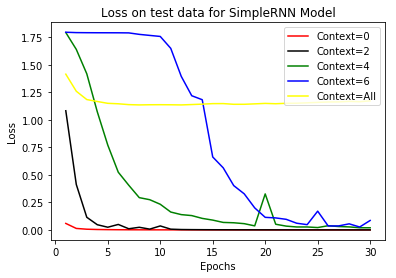

In [314]:
import matplotlib.pyplot as plt
plt.figsize=(16,4)
history1_dict = history1.history
#history_dict.keys()
history2_dict = history2.history
history3_dict = history3.history
history4_dict = history4.history
history5_dict = history5.history
loss_values1 = history1_dict['val_loss']
loss_values2 = history2_dict['val_loss']
loss_values3 = history3_dict['val_loss']
loss_values4 = history4_dict['val_loss']
loss_values5 = history5_dict['val_loss']
epochs = range(1, len(history1_dict['acc']) + 1)
plt.plot(epochs,  loss_values1, 'b', label='Context=0',color='red')
plt.plot(epochs, loss_values2, 'b', label='Context=2', color='black')
plt.plot(epochs, loss_values3, 'b', label='Context=4', color='green')
plt.plot(epochs, loss_values4, 'b', label='Context=6', color='blue')
plt.plot(epochs, loss_values5, 'b', label='Context=All', color='yellow')
plt.title('Loss on test data for SimpleRNN Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [198]:
#contet=8; 52 words; 100 iterations
import os
import sys
train=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_train.txt')
test=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_test.txt')
context=-1
X_tr,Q_tr,y_tr,X_te,Q_te,y_te,model=create_model(train,test,context)
print('Training')
history=model.fit([X_tr, Q_tr], y_tr,batch_size=32,epochs=100, verbose=1,validation_split=0.1)
print('Evaluation')
loss, acc = model.evaluate([X_te,Q_te], y_te,batch_size=32)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss, acc))

Training
Train on 9000 samples, validate on 1000 samples
Epoch 1/100
9000/9000 [==============================] - 12s 1ms/step - loss: 1.8982 - acc: 0.4246 - val_loss: 1.4236 - val_acc: 0.5380
Epoch 2/100
9000/9000 [==============================] - 5s 505us/step - loss: 1.2948 - acc: 0.5433 - val_loss: 1.2422 - val_acc: 0.5370
Epoch 3/100
9000/9000 [==============================] - 5s 562us/step - loss: 1.1919 - acc: 0.5373 - val_loss: 1.1917 - val_acc: 0.5200.1891 - acc: 0.54 - ETA: 0s - loss: 1.19
Epoch 4/100
9000/9000 [==============================] - 5s 537us/step - loss: 1.1586 - acc: 0.5362 - val_loss: 1.1605 - val_acc: 0.5120
Epoch 5/100
9000/9000 [==============================] - 5s 511us/step - loss: 1.1365 - acc: 0.5364 - val_loss: 1.1549 - val_acc: 0.5180
Epoch 6/100
9000/9000 [==============================] - 5s 515us/step - loss: 1.1225 - acc: 0.5310 - val_loss: 1.1695 - val_acc: 0.5020
Epoch 7/100
9000/9000 [==============================] - 5s 515us/step - loss: 1.1

#### From these results, we can conclude that RNNs have limited capacity for storing large pieces of information. The performance drops signficantly after 41 words.

In [ ]:
### LSTMs for Question Answering:

In [243]:
def create_model_lstm(trainingData, testData, context):
    tokenizer,vocab_size=create_tokenizer(trainingData,testData)

    X_tr,Q_tr,y_tr,max_story_len_tr, max_query_len_tr=process_stories_n_context(trainingData,tokenizer,vocab_size,use_context=context)
    X_te,Q_te,y_te, max_story_len_te, max_query_len_te=process_stories_n_context(testData,tokenizer,vocab_size,use_context=context)

    max_story_len=max(max_story_len_tr, max_story_len_te)
    max_query_len=max(max_query_len_tr, max_query_len_te)

    X_tr=pad_sequences(X_tr,max_story_len)
    Q_tr=pad_sequences(Q_tr, max_query_len)
    X_te=pad_sequences(X_te,max_story_len)
    Q_te=pad_sequences(Q_te,max_query_len)

    embedding=layers.Embedding(vocab_size,100)

    story = layers.Input(shape=(max_story_len,), dtype='int32')
    encoded_story = embedding(story)
    encoded_story = LSTM(30)(encoded_story)

    question = layers.Input(shape=(max_query_len,), dtype='int32')
    encoded_question = embedding(question)
    encoded_question = LSTM(30)(encoded_question)

    merged = layers.concatenate([encoded_story, encoded_question])
    preds = layers.Dense(vocab_size, activation='softmax')(merged)

    model = Model([story, question], preds)
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    #print(X_te,Q_te)

    return X_tr,Q_tr,y_tr,X_te,Q_te,y_te,model



In [244]:
#contet=8; 52 words; 100 iterations
import os
import sys
train=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_train.txt')
test=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_test.txt')
context=-1
X_tr,Q_tr,y_tr,X_te,Q_te,y_te,model=create_model_lstm(train, test, context)
print('Training')
history=model.fit([X_tr, Q_tr], y_tr,batch_size=32,epochs=100, verbose=1,validation_split=0.1)
print('Evaluation')
loss, acc = model.evaluate([X_te,Q_te], y_te,batch_size=32)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss, acc))

Training
Train on 9000 samples, validate on 1000 samples
Epoch 1/100
9000/9000 [==============================] - 23s 3ms/step - loss: 2.1014 - acc: 0.3307 - val_loss: 1.5165 - val_acc: 0.5380
Epoch 2/100
9000/9000 [==============================] - 15s 2ms/step - loss: 1.4358 - acc: 0.5408 - val_loss: 1.4108 - val_acc: 0.5380
Epoch 3/100
9000/9000 [==============================] - 14s 2ms/step - loss: 1.3856 - acc: 0.5427 - val_loss: 1.3670 - val_acc: 0.5380
Epoch 4/100
9000/9000 [==============================] - 13s 1ms/step - loss: 1.2860 - acc: 0.5406 - val_loss: 1.2538 - val_acc: 0.5380
Epoch 5/100
9000/9000 [==============================] - 16s 2ms/step - loss: 1.1743 - acc: 0.5376 - val_loss: 1.1391 - val_acc: 0.5400
Epoch 6/100
9000/9000 [==============================] - 18s 2ms/step - loss: 1.1074 - acc: 0.5382 - val_loss: 1.1175 - val_acc: 0.5320
Epoch 7/100
9000/9000 [==============================] - 16s 2ms/step - loss: 1.0767 - acc: 0.5341 - val_loss: 1.1031 - val_acc

#### We see that LSTMs push the boundary a bit further compared to RNNs. But, similar to RNNs, they fail on long sequences, displaying an abrupt decline in accuracy. We conclude that neither LSTMs or RNNs are adequate tools for handing very long sequences of facts for Question Answering. LSTMs outperform RNNs for moderately long contexts, but fail on extensive sequences.

In [270]:
def create_model_nnm(trainingData, testData, context):
    #import merge

    tokenizer,vocab_size=create_tokenizer(trainingData,testData)

    X_tr,Q_tr,y_tr,max_story_len_tr, max_query_len_tr=process_stories_n_context(trainingData,tokenizer,vocab_size,use_context=context)
    X_te,Q_te,y_te, max_story_len_te, max_query_len_te=process_stories_n_context(testData,tokenizer,vocab_size,use_context=context)

    max_story_len=max(max_story_len_tr, max_story_len_te)
    max_query_len=max(max_query_len_tr, max_query_len_te)

    X_tr=pad_sequences(X_tr,max_story_len)
    Q_tr=pad_sequences(Q_tr, max_query_len)
    X_te=pad_sequences(X_te,max_story_len)
    Q_te=pad_sequences(Q_te,max_query_len)

    input = Input((max_story_len,))
    question = Input((max_query_len,))

    A= Embedding(input_dim=vocab_size,output_dim=64)
    C=Embedding(input_dim=vocab_size, output_dim=max_query_len)
    B=Embedding(input_dim=vocab_size,output_dim=64,input_length=max_query_len)

    input_A = A(input)
    input_C = C(input)
    question_B = B(question)

    input_question_match = dot([input_A, question_B], axes=(2, 2))
    Probs = Activation('softmax')(input_question_match)

    O = add([Probs, input_C])
    O = Permute((2, 1))(O)

    final_match = concatenate([O, question_B])

    size=keras.backend.int_shape(final_match)[2]
    weights = Dense(size, activation='softmax')(final_match)

    merged=layers.multiply([final_match, weights])
    answer=Flatten()(merged)

    answer = Dense(vocab_size)(answer)
    answer = Activation('softmax')(answer)

    model = Model([input, question], answer)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
    #model.summary()

    return X_tr,Q_tr,y_tr,X_te,Q_te,y_te,model

create_model_nnm(train,test,context)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_107 (InputLayer)          (None, 58)           0                                            
__________________________________________________________________________________________________
input_108 (InputLayer)          (None, 3)            0                                            
__________________________________________________________________________________________________
embedding_74 (Embedding)        (None, 58, 64)       9472        input_107[0][0]                  
__________________________________________________________________________________________________
embedding_76 (Embedding)        (None, 3, 64)        9472        input_108[0][0]                  
__________________________________________________________________________________________________
dot_11 (Do

(array([[ 0,  0,  0, ...,  1,  2, 12],
        [ 0,  0,  0, ...,  1,  2, 14],
        [ 0,  0,  0, ...,  1,  2, 10],
        ...,
        [ 0,  0,  0, ...,  1,  2, 13],
        [ 0,  0,  0, ...,  1,  2, 10],
        [ 0,  0,  0, ...,  1,  2, 15]]), array([[3, 4, 8],
        [3, 4, 9],
        [3, 4, 9],
        ...,
        [3, 4, 8],
        [3, 4, 6],
        [3, 4, 6]]), array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]), array([[ 0,  0,  0, ...,  1,  2, 10],
        [ 0,  0,  0, ...,  1,  2, 15],
        [ 0,  0,  0, ...,  1,  2, 13],
        ...,
        [ 0,  0,  0, ...,  1,  2, 15],
        [ 0,  0,  0, ...,  1,  2, 10],
        [ 0,  0,  0, ...,  1,  2, 14]]), array([[3, 4, 6],
        [3, 4, 8],
        [3, 4, 7],
        ...,
        [3, 4, 7],
        [3, 4, 7],
        [3, 4, 6]]),

In [272]:
#contet=8; 52 words; 100 iterations
import os
import sys
train=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_train.txt')
test=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_test.txt')
context=6
X_tr,Q_tr,y_tr,X_te,Q_te,y_te,model=create_model_nnm(train, test, context)
print('Training')
history=model.fit([X_tr, Q_tr], y_tr,batch_size=32,epochs=100, verbose=1,validation_split=0.1)
print('Evaluation')
loss, acc = model.evaluate([X_te,Q_te], y_te,batch_size=32)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss, acc))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_111 (InputLayer)          (None, 41)           0                                            
__________________________________________________________________________________________________
input_112 (InputLayer)          (None, 3)            0                                            
__________________________________________________________________________________________________
embedding_80 (Embedding)        (None, 41, 64)       9472        input_111[0][0]                  
__________________________________________________________________________________________________
embedding_82 (Embedding)        (None, 3, 64)        9472        input_112[0][0]                  
__________________________________________________________________________________________________
dot_13 (Do

In [275]:
#contet=8; 52 words; 100 iterations
import os
import sys
train=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_train.txt')
test=os.path.realpath('C:/Users/nisht/Desktop/MITA/capstone_project/qa1_single-supporting-fact_test.txt')
context=-1
X_tr,Q_tr,y_tr,X_te,Q_te,y_te,model1=create_model(train, test, context)
X_tr,Q_tr,y_tr,X_te,Q_te,y_te,model2=create_model_lstm(train, test, context)
X_tr,Q_tr,y_tr,X_te,Q_te,y_te,model3=create_model_nnm(train, test, context)
print('Training')
history1=model1.fit([X_tr, Q_tr], y_tr,batch_size=32,epochs=30, verbose=1,validation_split=0.1, shuffle=False)
history2=model2.fit([X_tr, Q_tr], y_tr,batch_size=32,epochs=30, verbose=1,validation_split=0.1, shuffle=False)
history3=model3.fit([X_tr, Q_tr], y_tr,batch_size=32,epochs=30, verbose=1,validation_split=0.1, shuffle=False)
print('Evaluation for SImpleRNN')
loss1, acc1 = model1.evaluate([X_te,Q_te], y_te,batch_size=32)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss1, acc1))

print('Evaluation for LSTM')
loss2, acc2 = model2.evaluate([X_te,Q_te], y_te,batch_size=32)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss2, acc2))

print('Evaluation for E-E-Memory')
loss3, acc3 = model3.evaluate([X_te,Q_te], y_te,batch_size=32)
print('Test loss / test accuracy = {:.4f} / {:.4f}'.format(loss3, acc3))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_117 (InputLayer)          (None, 41)           0                                            
__________________________________________________________________________________________________
input_118 (InputLayer)          (None, 3)            0                                            
__________________________________________________________________________________________________
embedding_85 (Embedding)        (None, 41, 64)       9472        input_117[0][0]                  
__________________________________________________________________________________________________
embedding_87 (Embedding)        (None, 3, 64)        9472        input_118[0][0]                  
__________________________________________________________________________________________________
dot_14 (Do

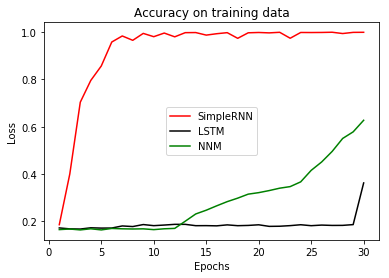

In [292]:
import matplotlib.pyplot as plt
plt.figsize=(16,4)
history1_dict = history1.history
#history_dict.keys()
history2_dict = history2.history
history3_dict = history3.history
acc_values1 = history1_dict['acc']
acc_values2 = history2_dict['acc']
acc_values3 = history3_dict['acc']
epochs = range(1, len(history1_dict['acc']) + 1)
plt.plot(epochs,  acc_values1, 'b', label='SimpleRNN',color='r')
plt.plot(epochs, acc_values2, 'b', label='LSTM', color='black')
plt.plot(epochs, acc_values3, 'b', label='NNM', color='green')
plt.title('Accuracy on training data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [293]:
history2_dict = history2.history
len(history2_dict['acc'])

30